In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import sys

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import Window

SparkAppName = 'alpha'

# spark_home = '/opt/cloudera/parcels/SPARK2/lib/spark2'
# os.environ['SPARK_HOME'] = spark_home
# os.environ['PYSPARK_DRIVER_PYTHON'] = 'python'
# os.environ['PYSPARK_PYTHON'] = '/opt/cloudera/parcels/PYENV.GPUAI-3.6.pyenv.p0.2/bin/python'
# os.environ['LD_LIBRARY_PATH'] = '/opt/python/virtualenv/jupyter/lib'
# sys.path.insert(0, os.path.join (spark_home,'python'))
# sys.path.insert(0, os.path.join (spark_home,'python/lib/py4j-0.10.7-src.zip'))

spark = SparkSession.builder\
    .appName(SparkAppName)\
    .master("local[*]")\
    .config('spark.driver.memory', '64g')\
    .config('spark.driver.maxResultSize', '16g')\
    .getOrCreate()

#     .master("yarn-client")\
#     .config('spark.dynamicAllocation.enabled', 'true')\
#     .config('spark.dynamicAllocation.minExecutors',4)\
#     .config('spark.executor.memory','10g')\
#     .config('spark.executor.cores', 7)\
#     .config('spark.yarn.executor.memoryOverhead', '10g')\
#     .config('spark.driver.memory', '6g')\
#     .config('spark.driver.maxResultSize','6g')\
#     .config('spark.kryoserializer.buffer.max', '1g')\
#     .config('spark.excludeOnFailure.enabled', 'true')\
#     .config('spark.excludeOnFailure.timeout', '3h')\
#     .config('spark.excludeOnFailure.task.maxTaskAttemptsPerNode', 2)\
#     .config('spark.sql.broadcastTimeout', 36000)\
#     .config('spark.sql.shuffle.partitions', 2000)\
#     .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
#     .enableHiveSupport()\

22/08/10 11:38:29 WARN Utils: Your hostname, vm2 resolves to a loopback address: 127.0.1.1; using 192.168.0.6 instead (on interface ens192)
22/08/10 11:38:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/10 11:38:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/10 11:38:31 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/10 11:38:31 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
!ls data_for_competition

description.xlsx       test_data	train_data
sample_submission.csv  test_target.csv	train_target.csv


In [4]:
train_target = spark.read.csv("data_for_competition/train_target.csv", header=True)
train_target.count()

3000000

In [5]:
test_target = spark.read.csv("data_for_competition/test_target.csv", header=True)
test_target.count()

500000

In [6]:
train_target.show()

+---+----+
| id|flag|
+---+----+
|  0|   0|
|  1|   0|
|  2|   0|
|  3|   0|
|  4|   0|
|  5|   0|
|  6|   0|
|  7|   0|
|  8|   0|
|  9|   0|
| 10|   0|
| 11|   0|
| 12|   0|
| 13|   0|
| 14|   0|
| 15|   0|
| 16|   0|
| 17|   0|
| 18|   0|
| 19|   0|
+---+----+
only showing top 20 rows



In [7]:
train_target.select(F.sum('flag')).collect()[0][0]

106442.0

In [8]:
106442/3000000*100

3.5480666666666667

In [9]:
train_data = spark.read.parquet("data_for_competition/train_data")
train_data.count()

26162717

In [10]:
test_data = spark.read.parquet("data_for_competition/test_data")
test_data.count()

4724601

In [11]:
print(len(train_data.dtypes))
train_data.dtypes

61


[('id', 'bigint'),
 ('rn', 'bigint'),
 ('pre_since_opened', 'bigint'),
 ('pre_since_confirmed', 'bigint'),
 ('pre_pterm', 'bigint'),
 ('pre_fterm', 'bigint'),
 ('pre_till_pclose', 'bigint'),
 ('pre_till_fclose', 'bigint'),
 ('pre_loans_credit_limit', 'bigint'),
 ('pre_loans_next_pay_summ', 'bigint'),
 ('pre_loans_outstanding', 'bigint'),
 ('pre_loans_total_overdue', 'bigint'),
 ('pre_loans_max_overdue_sum', 'bigint'),
 ('pre_loans_credit_cost_rate', 'bigint'),
 ('pre_loans5', 'bigint'),
 ('pre_loans530', 'bigint'),
 ('pre_loans3060', 'bigint'),
 ('pre_loans6090', 'bigint'),
 ('pre_loans90', 'bigint'),
 ('is_zero_loans5', 'bigint'),
 ('is_zero_loans530', 'bigint'),
 ('is_zero_loans3060', 'bigint'),
 ('is_zero_loans6090', 'bigint'),
 ('is_zero_loans90', 'bigint'),
 ('pre_util', 'bigint'),
 ('pre_over2limit', 'bigint'),
 ('pre_maxover2limit', 'bigint'),
 ('is_zero_util', 'bigint'),
 ('is_zero_over2limit', 'bigint'),
 ('is_zero_maxover2limit', 'bigint'),
 ('enc_paym_0', 'bigint'),
 ('enc_p

### Add 1 to all except rn col

In [12]:
for column in train_data.columns:
    if column != 'id' and column != 'rn' and column != 'enc_paym_24' and column != 'enc_paym_20' and column != 'enc_paym_11' and column != 'pre_loans90' and column != 'pre_loans_outstanding':
        train_data = train_data.withColumn(column, F.col(column) + F.lit(1))
        test_data = test_data.withColumn(column, F.col(column) + F.lit(1))


In [13]:
train_data.limit(100).toPandas()

22/08/10 11:38:43 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,250000,1,9,8,8,3,5,10,6,3,...,4,4,4,4,2,4,5,2,1,1
1,250000,2,15,9,13,11,7,4,13,7,...,4,4,4,4,2,4,5,2,1,1
2,250000,3,11,5,9,12,7,14,6,3,...,4,4,4,4,2,4,5,2,1,1
3,250000,4,14,13,9,7,14,6,13,3,...,4,4,4,4,2,4,5,2,1,1
4,250000,5,7,13,5,15,2,8,5,3,...,4,4,4,4,2,4,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,250014,7,7,3,1,9,15,12,12,3,...,1,1,1,1,2,3,4,2,1,2
96,250014,8,12,18,9,12,16,15,5,3,...,4,4,4,4,2,4,4,2,1,1
97,250014,9,2,10,5,9,2,12,16,6,...,4,4,4,4,2,3,4,2,2,2
98,250014,10,13,11,17,9,13,3,15,3,...,4,4,4,4,2,4,2,2,1,1


### Train

Num clients in train:  3000000



Max num trx:  58
Min num trx:  1
Mean num trx:  8.720905666666667

% of clients with 1 trx:  7.35
% of clients with 2 trx:  7.62
% of clients < 5 trx:  30.19
% of clients < 10 trx:  62.32
% of clients > 30 trx:  0.27


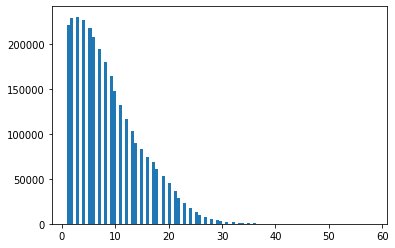

+------+------+
|    id|number|
+------+------+
|250267|     5|
|250622|    15|
|250722|     4|
|250780|    17|
|250953|     4|
|250956|     1|
|251092|    10|
|251310|     4|
|251492|    19|
|251605|     7|
|251719|     1|
|251952|     6|
|252057|    14|
|252993|    13|
|253095|     1|
|253232|    11|
|253472|    14|
|253498|     8|
|253804|    13|
|253815|     9|
+------+------+
only showing top 20 rows



In [14]:
import numpy as np
import matplotlib.pyplot as plt


agg = train_data.groupBy('id').agg(F.count(F.lit(1)).alias("number")).cache()

print()
print('Num clients in train: ', agg.count())
print()
print('Max num trx: ', agg.select(F.max('number').alias('max')).collect()[0]['max'])
print('Min num trx: ', agg.select(F.min('number').alias('min')).collect()[0]['min'])
print('Mean num trx: ', agg.select(F.mean('number').alias('mean')).collect()[0]['mean'])
print()
lens = np.array(agg.select('number').collect())
print('% of clients with 1 trx: ', round(np.sum(lens.squeeze() == 1)/len(lens) * 100, 2))
print('% of clients with 2 trx: ', round(np.sum(lens.squeeze() == 2)/len(lens) * 100, 2))
print('% of clients < 5 trx: ', round(np.sum(lens.squeeze() < 5)/len(lens) * 100, 2))
print('% of clients < 10 trx: ', round(np.sum(lens.squeeze() < 10)/len(lens) * 100, 2))
print('% of clients > 30 trx: ', round(np.sum(lens.squeeze() > 30)/len(lens) * 100, 2))
plt.hist(lens, bins=100)
plt.show()

agg.show()

### Test


Num clients in train:  500000

Max num trx:  57
Min num trx:  1
Mean num trx:  9.449202

% of clients with 1 trx:  6.94
% of clients with 2 trx:  7.07
% of clients < 5 trx:  27.84
% of clients < 10 trx:  57.5
% of clients > 30 trx:  0.37


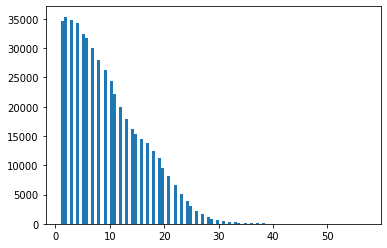

+-------+------+
|     id|number|
+-------+------+
|3250053|    12|
|3250074|     4|
|3250218|     3|
|3250294|    12|
|3250308|     8|
|3250333|    17|
|3250394|     1|
|3251104|     2|
|3251171|    21|
|3251607|    13|
|3251786|     1|
|3251883|    19|
|3252246|     6|
|3252721|     5|
|3252799|    18|
|3253046|     1|
|3253172|    17|
|3253292|     3|
|3253341|    21|
|3253386|    12|
+-------+------+
only showing top 20 rows



In [13]:
agg_test = test_data.groupBy('id').agg(F.count(F.lit(1)).alias("number")).cache()

print()
print('Num clients in train: ', agg_test.count())
print()
print('Max num trx: ', agg_test.select(F.max('number').alias('max')).collect()[0]['max'])
print('Min num trx: ', agg_test.select(F.min('number').alias('min')).collect()[0]['min'])
print('Mean num trx: ', agg_test.select(F.mean('number').alias('mean')).collect()[0]['mean'])
print()
lens_test = np.array(agg_test.select('number').collect())
print('% of clients with 1 trx: ', round(np.sum(lens_test.squeeze() == 1)/len(lens_test) * 100, 2))
print('% of clients with 2 trx: ', round(np.sum(lens_test.squeeze() == 2)/len(lens_test) * 100, 2))
print('% of clients < 5 trx: ', round(np.sum(lens_test.squeeze() < 5)/len(lens_test) * 100, 2))
print('% of clients < 10 trx: ', round(np.sum(lens_test.squeeze() < 10)/len(lens_test) * 100, 2))
print('% of clients > 30 trx: ', round(np.sum(lens_test.squeeze() > 30)/len(lens_test) * 100, 2))
plt.hist(lens_test, bins=100)
plt.show()

agg_test.show()

In [14]:
np.sum(lens.squeeze() < 2)/len(lens)* 100

7.3515

### Number of categories

In [14]:
for col in train_data.columns:
    distinct_in_col_train = train_data.select(F.col(col)).distinct()
    distinct_in_col_test = test_data.select(F.col(col)).distinct()
    print('{0: <30} {1: <10} {2: <10} {3: <10} |     {4: <10} {5: <10} {6}'.format(col, train_data.select(F.col(col)).distinct().count(),
                                                                                  distinct_in_col_train.select(F.min(F.col(col))).toPandas().to_numpy().squeeze().tolist(),
                                                                                  distinct_in_col_train.select(F.max(F.col(col))).toPandas().to_numpy().squeeze().tolist(),
                                                                                  test_data.select(F.col(col)).distinct().count(),
                                                                                  distinct_in_col_test.select(F.min(F.col(col))).toPandas().to_numpy().squeeze().tolist(),
                                                                                  distinct_in_col_test.select(F.max(F.col(col))).toPandas().to_numpy().squeeze().tolist()
                                                                            )
    )

id                             3000000    0          2999999    |     500000     3000000    3499999
rn                             58         1          58         |     57         1          57
pre_since_opened               20         1          20         |     20         1          20
pre_since_confirmed            18         1          18         |     17         1          18
pre_pterm                      18         1          18         |     18         1          18
pre_fterm                      17         1          17         |     17         1          17
pre_till_pclose                17         1          17         |     17         1          17
pre_till_fclose                16         1          16         |     16         1          16
pre_loans_credit_limit         20         1          20         |     20         1          20
pre_loans_next_pay_summ        7          1          7          |     8          1          8
pre_loans_outstanding          5          1   

### Check for missing values

In [40]:
# for c in train_data.columns:
#     print(np.sum(train_data.select([F.count(F.when(F.isnan(c) | F.isnull(c), c))]).toPandas().to_numpy().squeeze()))

### Check for zeros

In [14]:
# for c in train_data.columns:
#     print(np.sum(train_data.filter(train_data[c] == 0).limit(100).toPandas().to_numpy().squeeze()), c)

### Collect lists

In [14]:
# full_train_df = train_data.groupBy('id').agg(*[F.collect_list(col).alias(col) for col in train_data.columns if col != 'id']).join(train_target, ['id']).withColumn('rn', F.reverse('rn'))
# full_train_df = full_train_df.withColumn('flag', full_train_df['flag'].cast('int')).cache()
# valid_df = full_train_df.sample(0.01).cache()
# train_df = full_train_df.join(valid_df, full_train_df.id == valid_df.id, how='left_anti').cache()
# test_df = test_data.groupBy('id').agg(*[F.collect_list(col).alias(col) for col in test_data.columns if col != 'id']).withColumn('rn', F.reverse('rn')).cache()

# print('Full train size:', full_train_df.count())
# print('Valid size:', valid_df.count())
# print('Train size:', train_df.count())
# print('Test size:', test_df.count())

# full_train_df.write.parquet("./full_train.parquet")
# train_df.write.parquet("./train.parquet")
# valid_df.write.parquet("./valid.parquet")
# test_df.write.parquet("./test.parquet")

full_train_df = spark.read.parquet("./full_train.parquet")
train_df = spark.read.parquet("./train.parquet")
valid_df = spark.read.parquet("./valid.parquet")
test_df = spark.read.parquet("./test.parquet")

In [15]:
# full_train_df_gt2 = full_train_df.filter(F.size(full_train_df.rn) > 2)
# full_train_df_gt2.write.parquet("./full_train_gt2.parquet")

# valid_df_gt2 = full_train_df_gt2.sample(0.01).cache()
# train_df_gt2 = full_train_df_gt2.join(valid_df_gt2, full_train_df_gt2.id == valid_df_gt2.id, how='left_anti').cache()

# train_df_gt2.write.parquet("./train_gt2.parquet")
# valid_df_gt2.write.parquet("./valid_gt2.parquet")

full_train_df_gt2 = spark.read.parquet("./full_train_gt2.parquet")
train_df_gt2 = spark.read.parquet("./train_gt2.parquet")
valid_df_gt2 = spark.read.parquet("./valid_gt2.parquet")

In [16]:
valid_df_gt2.select(F.sum('flag')).collect()[0][0] / 30180 * 100

2.753479125248509

In [17]:
train_df_gt2.limit(100).toPandas()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
0,99,"[7, 6, 5, 4, 3, 2, 1]","[9, 14, 7, 7, 19, 2, 20]","[9, 10, 9, 6, 10, 10, 10]","[10, 8, 15, 5, 2, 15, 11]","[9, 7, 8, 9, 17, 8, 14]","[5, 14, 2, 2, 12, 11, 11]","[12, 6, 12, 12, 1, 5, 5]","[6, 20, 8, 11, 12, 12, 11]","[3, 5, 3, 7, 7, 5, 7]",...,"[4, 4, 4, 1, 1, 4, 4]","[4, 4, 4, 1, 1, 4, 4]","[4, 4, 4, 1, 4, 4, 4]","[2, 2, 2, 2, 2, 2, 2]","[6, 4, 3, 3, 4, 3, 3]","[5, 5, 5, 4, 5, 5, 5]","[2, 2, 2, 2, 2, 2, 2]","[1, 1, 1, 2, 1, 1, 1]","[2, 1, 1, 2, 1, 1, 1]",0
1,444,"[5, 4, 3, 2, 1]","[14, 7, 7, 19, 8]","[15, 15, 10, 10, 17]","[14, 4, 5, 16, 8]","[3, 6, 9, 10, 7]","[14, 4, 2, 6, 8]","[6, 6, 12, 8, 3]","[7, 14, 9, 2, 7]","[3, 3, 4, 5, 3]",...,"[4, 4, 1, 4, 4]","[4, 4, 1, 4, 4]","[4, 4, 4, 4, 4]","[2, 2, 2, 2, 2]","[4, 4, 3, 4, 4]","[5, 5, 4, 5, 5]","[2, 2, 2, 2, 2]","[1, 1, 2, 1, 1]","[1, 1, 2, 1, 1]",0
2,510,"[13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]","[9, 16, 11, 11, 1, 14, 14, 7, 7, 5, 6, 4, 10]","[6, 4, 5, 4, 13, 9, 4, 4, 9, 7, 4, 7, 11]","[5, 10, 14, 14, 7, 18, 1, 10, 2, 5, 13, 8, 15]","[9, 1, 3, 3, 9, 15, 14, 13, 17, 13, 11, 12, 9]","[2, 10, 7, 7, 15, 6, 13, 4, 12, 2, 16, 12, 11]","[12, 2, 14, 14, 12, 11, 15, 11, 1, 8, 15, 1, 12]","[14, 4, 20, 20, 13, 9, 12, 17, 10, 17, 12, 14, 8]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 2, 3]",...,"[4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 1, 4, 4]","[4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 1, 4, 4]","[4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3]","[5, 2, 5, 2, 4, 5, 4, 2, 5, 4, 5, 5, 4]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1]","[2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2]",0
3,617,"[20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9...","[9, 9, 9, 9, 9, 15, 15, 11, 1, 1, 14, 14, 14, ...","[18, 5, 5, 4, 12, 9, 10, 5, 5, 10, 11, 10, 10,...","[4, 2, 18, 8, 5, 2, 10, 14, 14, 17, 7, 15, 5, ...","[6, 17, 14, 7, 9, 15, 1, 1, 1, 7, 9, 15, 1, 9,...","[5, 7, 10, 10, 2, 14, 7, 7, 14, 14, 1, 3, 2, 2...","[10, 14, 4, 2, 12, 4, 14, 14, 4, 4, 12, 8, 6, ...","[6, 13, 18, 6, 5, 12, 6, 11, 20, 11, 3, 15, 11...","[3, 3, 3, 3, 3, 3, 7, 3, 2, 5, 3, 4, 5, 3, 5, ...",...,"[4, 1, 1, 4, 1, 4, 4, 4, 4, 4, 1, 1, 4, 1, 1, ...","[4, 1, 1, 4, 1, 4, 4, 4, 4, 4, 1, 2, 4, 1, 1, ...","[4, 1, 1, 4, 1, 4, 4, 4, 4, 4, 1, 4, 4, 1, 4, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 3, ...","[5, 5, 4, 2, 4, 5, 5, 5, 5, 5, 1, 5, 4, 5, 4, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, ...","[1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, ...",0
4,676,"[16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4,...","[15, 11, 1, 14, 14, 14, 7, 19, 19, 5, 5, 5, 6,...","[4, 5, 15, 6, 15, 15, 10, 13, 10, 10, 10, 18, ...","[9, 10, 13, 1, 14, 10, 14, 3, 5, 3, 5, 3, 14, ...","[7, 1, 16, 9, 3, 1, 3, 11, 15, 4, 11, 15, 1, 9...","[10, 14, 4, 13, 14, 14, 4, 17, 2, 12, 2, 12, 1...","[14, 4, 6, 12, 4, 6, 6, 8, 1, 11, 1, 1, 13, 12...","[6, 9, 9, 1, 9, 18, 4, 9, 9, 8, 15, 8, 12, 12,...","[3, 1, 5, 3, 1, 4, 2, 3, 4, 4, 6, 3, 6, 3, 1, 4]",...,"[4, 4, 4, 1, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4]","[4, 4, 4, 1, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4]","[4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3]","[2, 5, 5, 4, 5, 5, 5, 5, 4, 5, 4, 5, 5, 5, 4, 5]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1]","[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2]",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,15986,"[5, 4, 3, 2, 1]","[5, 18, 4, 4, 20]","[14, 13, 18, 11, 10]","[4, 4, 8

### trx_encoder params

In [18]:
feature_emb_dim = 16

numeric_values={'pre_loans_next_pay_summ': 'identity',
                'pre_loans5': 'identity',
                'pre_loans530': 'identity',
                'pre_loans3060': 'identity',
                'pre_loans6090': 'identity',
                'pre_loans90': 'identity'
}

embeddings={}
for col in train_data.columns:
    if col not in ['id'] + list(numeric_values.keys()):
        distinct_in_col_train = train_data.select(F.col(col)).distinct()
        max_train = distinct_in_col_train.select(F.max(F.col(col))).toPandas().to_numpy().squeeze().tolist()

        distinct_in_col_test = test_data.select(F.col(col)).distinct()
        max_test = distinct_in_col_test.select(F.max(F.col(col))).toPandas().to_numpy().squeeze().tolist()

        in_dim = max(max_train, max_test) + 1
        embeddings[col] = {'in': in_dim, 'out': feature_emb_dim}

embeddings


{'rn': {'in': 59, 'out': 16},
 'pre_since_opened': {'in': 21, 'out': 16},
 'pre_since_confirmed': {'in': 19, 'out': 16},
 'pre_pterm': {'in': 19, 'out': 16},
 'pre_fterm': {'in': 18, 'out': 16},
 'pre_till_pclose': {'in': 18, 'out': 16},
 'pre_till_fclose': {'in': 17, 'out': 16},
 'pre_loans_credit_limit': {'in': 21, 'out': 16},
 'pre_loans_outstanding': {'in': 6, 'out': 16},
 'pre_loans_total_overdue': {'in': 3, 'out': 16},
 'pre_loans_max_overdue_sum': {'in': 5, 'out': 16},
 'pre_loans_credit_cost_rate': {'in': 15, 'out': 16},
 'is_zero_loans5': {'in': 3, 'out': 16},
 'is_zero_loans530': {'in': 3, 'out': 16},
 'is_zero_loans3060': {'in': 3, 'out': 16},
 'is_zero_loans6090': {'in': 3, 'out': 16},
 'is_zero_loans90': {'in': 3, 'out': 16},
 'pre_util': {'in': 21, 'out': 16},
 'pre_over2limit': {'in': 21, 'out': 16},
 'pre_maxover2limit': {'in': 21, 'out': 16},
 'is_zero_util': {'in': 3, 'out': 16},
 'is_zero_over2limit': {'in': 3, 'out': 16},
 'is_zero_maxover2limit': {'in': 3, 'out': 1

### model

In [19]:
# def cpc_collate_fn(batch):
#     xs, ts = [], []
#     for rec in batch:
#         x, t = {k: v[:-2] for k, v in rec.items()}, {k: v[-2:] for k, v in rec.items()}
#         xs.append(x)
#         ts.append(t)
#     return padded_collate_wo_target(xs), padded_collate_wo_target(ts)


import numpy as np
import torch
import pytorch_lightning as pl
 
from omegaconf import DictConfig
from transformers import LongformerConfig, LongformerModel
 
from ptls.data_load.padded_batch import PaddedBatch
from torchmetrics import MeanMetric
from ptls.frames.bert.losses.query_soft_max import QuerySoftmaxLoss
from torch.nn import BCELoss
 

class ContrastivePredictionHead(torch.nn.Module):
   
    def __init__(self, embeds_dim, drop_p=0.1):
       
        super().__init__()
        self.head = torch.nn.Sequential(
            torch.nn.Linear(embeds_dim, embeds_dim, bias=True)
        )
 
    def forward(self, x):
        return self.head(x)


class MLMCPCPretrainModule(pl.LightningModule):
    def __init__(self,
                 trx_encoder: torch.nn.Module,
                 hidden_size: int,
                 loss_temperature: float,
                 total_steps: int,
                 max_lr: float = 0.001,
                 weight_decay: float = 0.0,
                 pct_start: float = 0.1,
                 norm_predict: bool = False,
                 num_attention_heads: int = 16,
                 intermediate_size: int = 128,
                 num_hidden_layers: int = 2,
                 attention_window: int = 16,
                 hidden_dropout_prob=0,
                 attention_probs_dropout_prob=0,
                 max_position_embeddings: int = 4000,
                 replace_proba: float = 0.1,
                 neg_count: int = 1,
                 log_logits: bool = False,
                 weight_mlm: float = 0.5,
                 weight_cpc: float = 0.5,
                 encode_seq = False
                 ):
        """
 
        Parameters
        ----------
        trx_encoder:
            Module for transform dict with feature sequences to sequence of transaction representations
        hidden_size:
            Output size of `trx_encoder`. Hidden size of internal transformer representation
        loss_temperature:
             temperature parameter of `QuerySoftmaxLoss`
        total_steps:
            total_steps expected in OneCycle lr scheduler
        max_lr:
            max_lr of OneCycle lr scheduler
        weight_decay:
            weight_decay of Adam optimizer
        pct_start:
            % of total_steps when lr increase
        norm_predict:
            use l2 norm for transformer output or not
        num_attention_heads:
            parameter for Longformer
        intermediate_size:
            parameter for Longformer
        num_hidden_layers:
            parameter for Longformer
        attention_window:
            parameter for Longformer
        max_position_embeddings:
            parameter for Longformer
        replace_proba:
            probability of masking transaction embedding
        neg_count:
            negative count for `QuerySoftmaxLoss`
        log_logits:
            if true than logits histogram will be logged. May be useful for `loss_temperature` tuning
        encode_seq:
            if true then outputs zero element of transformer i.e. encodes whole sequence. Else returns all outputs of transformer except 0th.
        """
 
        super().__init__()
        self.save_hyperparameters(logger=False)
 
        self.trx_encoder = trx_encoder
 
        self.token_cls = torch.nn.Parameter(torch.randn(1, 1, hidden_size), requires_grad=True)
        self.token_mask = torch.nn.Parameter(torch.randn(1, 1, hidden_size), requires_grad=True)
 
        self.transf = LongformerModel(
            config=LongformerConfig(
                hidden_size=hidden_size,
                num_attention_heads=num_attention_heads,
                intermediate_size=intermediate_size,
                num_hidden_layers=num_hidden_layers,
                vocab_size=4,
                max_position_embeddings=self.hparams.max_position_embeddings,
                attention_window=attention_window,
                hidden_dropout_prob=hidden_dropout_prob,
                attention_probs_dropout_prob=attention_probs_dropout_prob
            ),
            add_pooling_layer=False,
        )
       
        self.cpc_head1 = ContrastivePredictionHead(embeds_dim=hidden_size)
        self.cpc_head2 = ContrastivePredictionHead(embeds_dim=hidden_size)
       
        self.mlm_loss = QuerySoftmaxLoss(temperature=loss_temperature, reduce=False)
        self.cpc_loss = QuerySoftmaxLoss(temperature=loss_temperature, reduce=False)
       
        self.weight_mlm = weight_mlm
        self.weight_cpc = weight_cpc
 
        self.train_mlm_loss = MeanMetric(compute_on_step=False)
        self.valid_mlm_loss = MeanMetric(compute_on_step=False)
        
        self.train_cpc_loss = MeanMetric(compute_on_step=False)
        self.valid_cpc_loss = MeanMetric(compute_on_step=False)
 
        
        self.encode_seq = encode_seq
 
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(),
                                 lr=self.hparams.max_lr,
                                 weight_decay=self.hparams.weight_decay,
                                 )
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optim,
            max_lr=self.hparams.max_lr,
            total_steps=self.hparams.total_steps,
            pct_start=self.hparams.pct_start,
            anneal_strategy='cos',
            cycle_momentum=False,
            div_factor=25.0,
            final_div_factor=10000.0,
            three_phase=False,
        )
        scheduler = {'scheduler': scheduler, 'interval': 'step'}
        return [optim], [scheduler]
 
    def get_mask(self, attention_mask):
        return torch.bernoulli(attention_mask.float() * self.hparams.replace_proba).bool()
 
    def mask_x(self, x, attention_mask, mask):
        shuffled_tokens = x[attention_mask.bool()]
        B, T, H = x.size()
        ix = torch.multinomial(torch.ones(shuffled_tokens.size(0)), B * T, replacement=True)
        shuffled_tokens = shuffled_tokens[ix].view(B, T, H)
 
        rand = torch.rand(B, T, device=x.device).unsqueeze(2).expand(B, T, H)
        replace_to = torch.where(
            rand < 0.8,
            self.token_mask.expand_as(x),  # [MASK] token 80%
            torch.where(
                rand < 0.9,
                shuffled_tokens,  # random token 90%
                x,  # unchanged 10%
            )
        )
        return torch.where(mask.bool().unsqueeze(2).expand_as(x), replace_to, x)
 
    def forward(self, z: PaddedBatch):
        z = self.trx_encoder(z)
        
        B, T, H = z.payload.size()
        device = z.payload.device
 
        if self.training:
            start_pos = np.random.randint(0, self.hparams.max_position_embeddings - T - 1, 1)[0]
        else:
            start_pos = 0
 
        inputs_embeds = z.payload
        attention_mask = z.seq_len_mask.float()
 
        inputs_embeds = torch.cat([
            self.token_cls.expand(inputs_embeds.size(0), 1, H),
            inputs_embeds,
        ], dim=1)
        attention_mask = torch.cat([
            torch.ones(inputs_embeds.size(0), 1, device=device),
            attention_mask,
        ], dim=1)
        position_ids = torch.arange(T + 1, device=z.device).view(1, -1).expand(B, T + 1) + start_pos
        global_attention_mask = torch.cat([
            torch.ones(inputs_embeds.size(0), 1, device=device),
            torch.zeros(inputs_embeds.size(0), inputs_embeds.size(1) - 1, device=device),
        ], dim=1)
 
        out = self.transf(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
            position_ids=position_ids,
            global_attention_mask=global_attention_mask,
        ).last_hidden_state
 
        if self.hparams.norm_predict:
            out = out / (out.pow(2).sum(dim=-1, keepdim=True) + 1e-9).pow(0.5)
       
        # CPC Predictions
        cpc_preds1 = self.cpc_head1.forward(out[:, 0])
        cpc_preds2 = self.cpc_head2.forward(out[:, 0])
       
        if self.encode_seq:
            return out[:, 0]
        else:
            return PaddedBatch(out[:, 1:], z.seq_lens), [cpc_preds1, cpc_preds2]
 
    def get_neg_ix(self, mask):
        """Sample from predicts, where `mask == True`, without self element.
        sample from predicted tokens from batch
        """
        mask_num = mask.int().sum()
        mn = 1 - torch.eye(mask_num, device=mask.device)
        neg_ix = torch.multinomial(mn, max(1, int(mn.shape[-1]*0.09)))  # self.hparams.neg_count
 
        b_ix = torch.arange(mask.size(0), device=mask.device).view(-1, 1).expand_as(mask)[mask][neg_ix]
        t_ix = torch.arange(mask.size(1), device=mask.device).view(1, -1).expand_as(mask)[mask][neg_ix]
        return b_ix, t_ix
 
    def loss_mlm_cpc(self, x: PaddedBatch, y: PaddedBatch, is_train_step):
       
        mask = self.get_mask(x.seq_len_mask)
        masked_x = self.mask_x(x.payload, x.seq_len_mask, mask)
        out, preds  = self.forward(PaddedBatch(masked_x, x.seq_lens))
       
        # MlM Part
        out = out.payload
        mask = mask
        target = x.payload[mask].unsqueeze(1)  # N, 1, H
        predict = out[mask].unsqueeze(1)  # N, 1, H
        neg_ix = self.get_neg_ix(mask)
        negative = out[neg_ix[0], neg_ix[1]]  # N, nneg, H
        loss_mlm = self.mlm_loss(target, predict, negative)
 
        if is_train_step and self.hparams.log_logits:
            with torch.no_grad():
                logits = self.mlm_loss.get_logits(target, predict, negative)
            self.logger.experiment.add_histogram('mlm/logits',
                                                 logits.flatten().detach(), self.global_step)
           
            
        # CPC Part 
        targets, predicts, negatives = [], [], []
        for i in range(2):
            target = y.payload[:, i].unsqueeze(1)  # B, 1, H
            predict = preds[i].unsqueeze(1)  # B, 1, H
 
            # Sample negatives along batch_size dimension
            batch_size = predict.size(0)
            mn = 1 - torch.eye(batch_size, device=target.device)
            neg_ix = torch.multinomial(mn, max(1, int(mn.shape[-1]*0.07)))  # self.hparams.neg_count
            negative = preds[i][neg_ix, :]  # B, nneg, H
            targets.append(target)
            predicts.append(predict)
            negatives.append(negative)
       
        targets = torch.concat(targets, dim=0)
        predicts = torch.concat(predicts, dim=0)
        negatives = torch.concat(negatives, dim=0)
       
        # Feed contrastive loss with negatives
        loss_cpc = self.cpc_loss(targets, predicts, negatives) 
    
        return loss_mlm, loss_cpc
 
    def training_step(self, batch, batch_idx):
        x_trx, y_trx = batch
       
        z_trx = self.trx_encoder(x_trx)  # PB: B, T, H
        y_trx = self.trx_encoder(y_trx)  #     B, 3, H
        loss_mlm, loss_cpc = self.loss_mlm_cpc(z_trx, y_trx, is_train_step=True)
        self.train_mlm_loss(loss_mlm)
        self.train_cpc_loss(loss_cpc)
        loss_mlm = loss_mlm.mean()
        loss_cpc = loss_cpc.mean()
        self.log(f'mlm/loss', loss_mlm)
        self.log(f'cpc/loss', loss_cpc)
        loss = self.weight_cpc*loss_cpc + self.weight_mlm*loss_mlm
        return loss
 
    def validation_step(self, batch, batch_idx):
        x_trx, y_trx = batch
        z_trx = self.trx_encoder(x_trx)  # PB: B, T, H
        y_trx = self.trx_encoder(y_trx)
        loss_mlm, loss_cpc = self.loss_mlm_cpc(z_trx, y_trx, is_train_step=False)
        self.valid_cpc_loss(loss_cpc)
        self.valid_mlm_loss(loss_mlm)
 
    def training_epoch_end(self, _):
        self.log(f'mlm/train_mlm_loss', self.train_mlm_loss, prog_bar=False)
        self.log(f'cpc/train_cpc_loss', self.train_cpc_loss, prog_bar=False)
 
    def validation_epoch_end(self, _):
        self.log(f'mlm/valid_mlm_loss', self.valid_mlm_loss, prog_bar=True)
        self.log(f'cpc/valid_cpc_loss', self.valid_cpc_loss, prog_bar=False)

In [20]:
import numpy as np
import random
from functools import partial
import torch
import pytorch_lightning as pl
import torchmetrics
from ptls.frames.supervised import SequenceToTarget
from ptls.nn import Head

torch.multiprocessing.set_sharing_strategy('file_system')

pl.seed_everything(80, workers=True)
# torch.manual_seed(80)
# random.seed(80)
# np.random.seed(80)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(True)

INFO:pytorch_lightning.utilities.seed:Global seed set to 80


# Supervised, no pretrain

In [21]:
import torch
from ptls.nn import TrxEncoder, LongformerEncoder
from ptls.frames.bert import MLMPretrainModule
from ptls.nn import PBLinear, PBL2Norm, PBLayerNorm, PBDropout

In [22]:
trx_encoder_params = dict(
    embeddings_noise=0,
    numeric_values=numeric_values,
    embeddings=embeddings,
    emb_dropout=0.3,
    spatial_dropout=False
)

trx_encoder = TrxEncoder(**trx_encoder_params)

In [23]:
seq_encoder = MLMCPCPretrainModule(
    trx_encoder=torch.nn.Sequential(
        trx_encoder,
        PBLinear(trx_encoder.output_size, 64),
        PBDropout(0.2)
    ),
    hidden_size=64,
    loss_temperature=20.0,

    total_steps=30000,

    replace_proba=0.1,
    neg_count=64,

    log_logits=False,
    
    encode_seq=True
)

/home/alge/.local/share/virtualenvs/pytorch-lifestream-j3MrdFh4/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'trx_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['trx_encoder'])`.
  rank_zero_warn(


In [24]:
downstream_model = SequenceToTarget(
    seq_encoder=seq_encoder,
    head=Head(
        input_size=64,
        hidden_layers_sizes=[32, 8],
        drop_probs=[0.1, 0],
        use_batch_norm=True,
        objective='classification',
        num_classes=2,
    ),
    loss=torch.nn.NLLLoss(),
    metric_list=torchmetrics.AUROC(num_classes=2, compute_on_step=False),
    pretrained_lr=0.001,
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=2000, gamma=1),
)

/home/alge/.local/share/virtualenvs/pytorch-lifestream-j3MrdFh4/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [25]:
from ptls.data_load.datasets import ParquetDataset, ParquetFiles
from ptls.data_load.iterable_processing import SeqLenFilter, FeatureFilter, ToTorch
from ptls.frames.supervised.seq_to_target_dataset import SeqToTargetIterableDataset
from ptls.data_load import IterableChain
from ptls.frames import PtlsDataModule


train_pq_files = ParquetFiles('./train.parquet/')
valid_pq_files = ParquetFiles('./valid.parquet/')

train_dataset = ParquetDataset(data_files=train_pq_files.data_files, shuffle_files=True)
valid_dataset = ParquetDataset(data_files=valid_pq_files.data_files, shuffle_files=True)

finetune_dm = PtlsDataModule(
    train_data=SeqToTargetIterableDataset(train_dataset, target_col_name='flag'),
    valid_data=SeqToTargetIterableDataset(valid_dataset, target_col_name='flag'),
    train_num_workers=20,
    train_batch_size=1024,
    valid_batch_size=1024,
)

In [26]:
logger = pl.loggers.TensorBoardLogger(
                save_dir='lightning_logs',
                version='_super_no_pretrain_16_heads_2_layers_no_dropout_at_all_no_norm_emb_drop_0.3_PBDrop_0.2_no_transf_norm_FOLD1_plus_drop_in_head_0.1'
            )


checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath="./ckpts/_super_no_pretrain_16_heads_2_layers_no_dropout_at_all_no_norm_emb_drop_0.3_PBDrop_0.2_no_transf_norm_FOLD1_plus_drop_in_head_0.1/", save_top_k=40, mode='max', monitor="val_AUROC")

trainer_ft = pl.Trainer(
    max_epochs=100,
    gpus=1 if torch.cuda.is_available() else 0,
    enable_progress_bar=True,
    callbacks=[checkpoint_callback],
    logger=logger
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
print(f'logger.version = {trainer_ft.logger.version}')
trainer_ft.fit(downstream_model, finetune_dm)
print(trainer_ft.logged_metrics)

logger.version = _super_no_pretrain_16_heads_2_layers_no_dropout_at_all_no_norm_emb_drop_0.3_PBDrop_0.2_no_transf_norm_FOLD1_plus_drop_in_head_0.1


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                 | Params
-------------------------------------------------------
0 | seq_encoder   | MLMCPCPretrainModule | 420 K 
1 | head          | Head                 | 2.4 K 
2 | loss          | NLLLoss              | 0     
3 | train_metrics | ModuleDict           | 0     
4 | valid_metrics | ModuleDict           | 0     
5 | test_metrics  | ModuleDict           | 0     
-------------------------------------------------------
422 K     Trainable params
0         Non-trainable params
422 K     Total params
1.690     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/alge/.local/share/virtualenvs/pytorch-lifestream-j3MrdFh4/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/home/alge/.local/share/virtualenvs/pytorch-lifestream-j3MrdFh4/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

